#### Carga de datos

In [1]:
# requerimentos

from google.colab import drive
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import csv
from collections import Counter 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
from keras.models import load_model



drive.mount('/content/drive')

#Nota: Verificar que existe la ruta: /content/drive/MyDrive/UrbanSound8K

Mounted at /content/drive


In [2]:
### Usamos librosa para leer archivos de audio

audio_file_path='/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/Puntos1-50/Splits/Grabación (2).m4a'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)  # Se carga el archivo de audio en la variable librosa_audio_data y frecuencia de muestreo, por defecto 22050

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


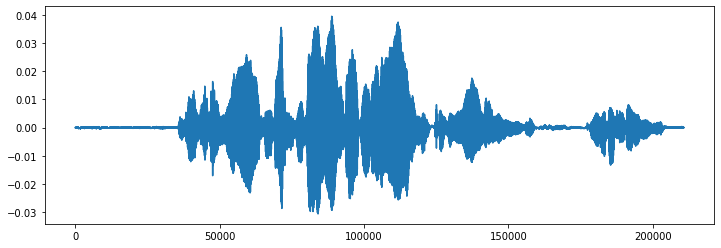

In [3]:
### Gráfica de audio: librosa reune los dos canales estéreo y lo convierte a un solo canal, con niveles normalizados entre 0 y 
##La frecuencia de muestreo también queda normalizada a 22050 muestras por segundo

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

###   Extracción de características

Aquí usamos los llamados coeficientes cepstrales de frecuencia mel (MFCC).
Los coeficientes cepstrales de frecuencia mel (MFCC) se utilizan comúnmente en los sistemas de reconocimiento de voz. Esta característica se deriva de la transformada de Fourier de una señal. Los coeficientes obtenidos a partir de la transformada de Fourier se convierten entonces a la escala Mel-frequency, que se asemeja más al oído humano (en decibeles). Finalmente, estos coeficientes se toman como entrada para una transformación cosenoidal, que produce un conjunto de coeficientes que se pueden usar como características para algoritmos de aprendizaje automático.

La función mfcc() de Librosa calcula los coeficientes MFCC (Mel-Frequency Cepstral Coefficients) a partir del audio. Los parámetros que se le pasan son:

y : la data del audio, en este caso librosa_audio_data . sr : el sample rate del audio, en este caso librosa_sample_rate=22050 . n_mfcc : el número de coeficientes MFCC que queremos obtener. En nuestro ejemplo hemos puesto 40:


In [4]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 412)


In [5]:
mfccs

array([[-7.9278198e+02, -7.8778149e+02, -7.8445856e+02, ...,
        -7.6514667e+02, -7.6602789e+02, -7.8544562e+02],
       [ 2.3810198e+01,  3.0660618e+01,  3.5028305e+01, ...,
         2.6123592e+01,  2.1131966e+01,  2.1139870e+01],
       [ 2.2608212e+01,  2.8810144e+01,  3.2325752e+01, ...,
         3.7485718e+01,  3.5509155e+01,  2.4579615e+01],
       ...,
       [-3.9253068e-01, -1.8957119e+00, -4.5263296e-01, ...,
        -5.5598984e+00, -1.7080261e+00, -2.4898505e+00],
       [ 5.4560864e-01, -1.2234037e+00, -9.7712219e-02, ...,
        -7.3498216e+00, -1.0116992e+01, -6.8009853e+00],
       [ 1.1143079e+00, -6.6907465e-01,  1.9910938e-01, ...,
        -2.5152607e+00, -1.9100063e+00, -2.8501046e-01]], dtype=float32)

In [6]:

df = pd.read_csv('/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/UrbanSound8K/metadata/UrbanSound8K.csv') 
df = df.sample(8732) 
df.to_csv('dataset2.csv', index=False)


In [7]:
#### Examinando el dataset de audio

audio_dataset_path='/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/UrbanSound8K/audio'
metadata=pd.read_csv('dataset2.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,147926-0-0-4.wav,147926,2.0,6.0,1,2,0,air_conditioner
1,161005-2-0-4.wav,161005,2.0,6.0,2,9,2,children_playing
2,34952-8-0-3.wav,34952,1.5,5.5,2,6,8,siren
3,194458-9-0-34.wav,194458,17.0,21.0,2,4,9,street_music
4,105415-2-0-6.wav,105415,3.0,7.0,1,1,2,children_playing


In [8]:
#A continuación se construye un extractor de características mfcc para cada archivo de audio

def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')  #cargamos el archivo de audio, el filtro kaiser se usa para filtrar ruido en la señal
    #extraemos las características MFCC. La variable n_mfcc=40 significa extraer 40 features MFCC de cada archivo de audio.   
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # l siguiente línea calcula la media de las características MFCC y las devuelve como una matriz de 1D. 
    # La función mfcc devuelve la matriz MFCC en la forma de (n_mfcc(40), n_samples(22050)). 
    #La función mean requiere que la matriz MFCC esté en la forma de (n_samples, n_mfcc). Por lo tanto, es necesario transponer la matriz MFCC.
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features #La matriz mfccs_scaled_features queda de tamaño 1x40, se extrajo la media de los 22050 samples
    

#Ahora se extraen todos los coeficientes de todos los archivos de audio del conjunto de datos



In [9]:
#Convertir esto en una tabla -- por hacer

extracted_features=[] 
for index_num,row in tqdm(metadata.iterrows()): 
  file_name = os.path.join(os.getcwd() + '/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/UrbanSound8K/audio','fold'+str(row["fold"])+'/',str(row["slice_file_name"])) 

  final_class_labels=row["class"] 
  data=features_extractor(file_name) 
  extracted_features.append([data,final_class_labels])#la matriz de mfccs de los archivos de audio se almacena junto con el label de la clase del archivo de audio.

2358it [15:39,  3.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
4068it [26:43,  2.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
4360it [28:28,  2.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8732it [55:44,  2.61it/s]


In [36]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()


,feature,class
0,"[-315.9747, 153.46362, -3.007722, 30.699106, 9...",air_conditioner
1,"[-225.5359, 133.75406, -42.700287, 30.955713, ...",children_playing
2,"[-571.40576, 169.89052, -14.6066065, 19.571056...",siren
3,"[-307.56174, 152.30336, -29.547773, 33.34747, ...",street_music
4,"[-212.17639, 124.732376, -44.277145, 13.858212...",children_playing


In [41]:
# guardar dataset de características
extracted_features_df.to_csv("extract.csv")

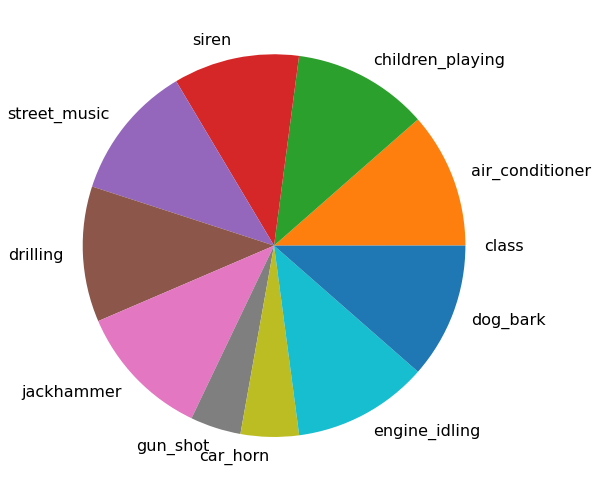

In [11]:
## ver las clases de sonido de Urban
 
plt.style.use('seaborn-poster')


with open('/content/dataset2.csv', 'r') as f:
#with open('/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/UrbanSound8K/metadata/UrbanSound8K.csv', 'r') as f: 
  reader = csv.reader(f) 
  types = [row[7] for row in reader] 
  counts = Counter(types) 
  labels, values = zip(*counts.items()) 
  plt.pie(values, labels=labels) 
  plt.show()



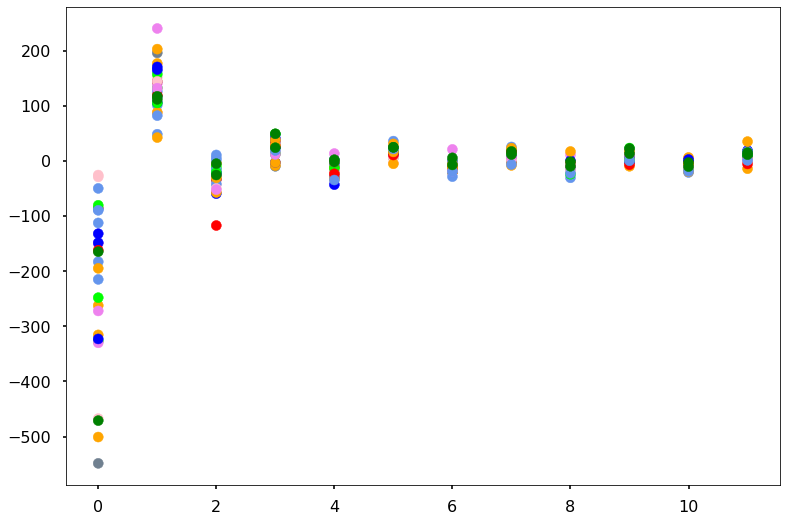

In [12]:
### Se separa la variable independiente (coeficientes) de la variable dependiente (clase de audio)
X=np.array(extracted_features_df['feature'].tolist()) #var independiente
y=np.array(extracted_features_df['class'].tolist()) #var dependiente


X_traingraph,X_testgraph,y_traingraph,y_testgraph=train_test_split(X,y,test_size=0.003,random_state=0)
ynew = []
for i in range(len(y_testgraph)):
    if y_testgraph[i] == "dog_bark":  
        ynew.append("orange")

    if y_testgraph[i] == "drilling":  
        ynew.append("blue") 

    if y_testgraph[i] == "jackhammer":  
        ynew.append("cornflowerblue") 

    if y_testgraph[i] == "engine_idling":  
        ynew.append("lime") 

    if y_testgraph[i] == "siren":  
        ynew.append("slategrey") 

    if y_testgraph[i] == "gun_shot":  
        ynew.append("pink")

    if y_testgraph[i] == "street_music":  
        ynew.append("brown")

    if y_testgraph[i] == "air_conditioner":  
        ynew.append("violet")

    if y_testgraph[i] == "car_horn":  
        ynew.append("red")

    if y_testgraph[i] == "children_playing":  
        ynew.append("green")


ynew = np.array(ynew)

sc = pd.DataFrame(X_testgraph).T  # Convierte la lista de listas en un dataframe y lo transpone (por defecto es por columnas)

                          # Itera sobre las columnas.
for i in range(12):  

      plt.scatter([i] * len(sc.iloc[i]), sc.iloc[i],c=ynew, s=100) 

plt.style.use('seaborn-talk')


In [13]:
X_testgraph.shape

(27, 40)

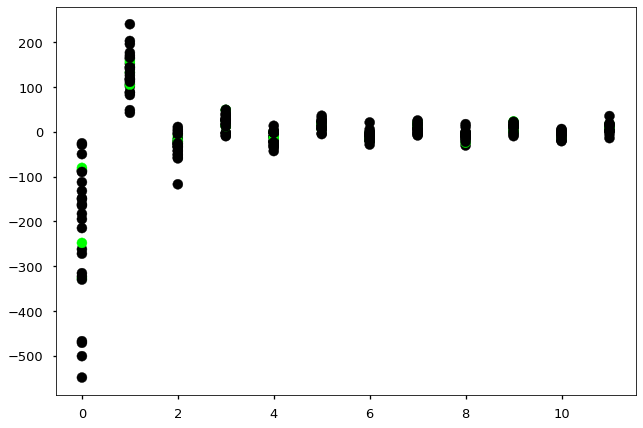

In [14]:


sc = pd.DataFrame(X_testgraph).T  # Convierte la lista de listas en un dataframe y lo transpone (por defecto es por columnas)
                          # Itera sobre las columnas.
for i in range(12):  
      
      plt.scatter([i] * len(sc.iloc[i]), sc.iloc[i],c=ynew=='lime', s=100, cmap = colors.ListedColormap(['black', 'lime'])) 

plt.style.use('seaborn-talk')
      



In [15]:
!pip install --upgrade tensorflow  # por si las moscas

     |████████████████████████████████| 462 kB 5.1 MB/s 


In [16]:
#se pasa y a variable categórica con una matriz de codificaciones (vectores de 10 elementos, donde la posición del 1 corresponde a la clase)


labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))


In [17]:
### Se separan los datos de prueba y entrenamiento

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Modelo

In [19]:
### Número de clases de audio
num_labels=y.shape[1] #numero de columnas en y (10)

num_labels

10

In [20]:


activation = 'softmax' if num_labels > 2 else 'sigmoid'
model = Sequential()
model.add(Conv1D(64, 3, input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(64, 3))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.4))
model.add(Dense(num_labels))
model.add(Activation('softmax' if num_labels > 2 else 'sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 64)            256       
                                                                 
 activation (Activation)     (None, 38, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            12352     
                                                                 
 dropout (Dropout)           (None, 36, 64)            0         
                                                                 
 activation_1 (Activation)   (None, 36, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 34, 128)           24704     
                                                                 
 activation_2 (Activation)   (None, 34, 128)           0

In [22]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam') # estamos usando categorical_crossentropy como nuestra función de pérdida porque tenemos un problema de clasificación multiclase


##Adam es una variación del algoritmo de optimización gradiente descendente estocástico. Es más eficiente que el algoritmo de descenso de gradiente clásico y, por lo tanto, se usa a menudo en la implementación de redes neuronales profundas.


In [23]:
#!pip install keras
#!pip install pydot
#!apt-get install graphviz -y

In [24]:
#from keras.utils import plot_model   # pip install pydot, pip install graphviz
#plot_model(model, to_file='model.png')

In [25]:
## Entrenamiento del modelo

num_epochs = 55
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/55
218/219 [============================>.] - ETA: 0s - loss: 1.8771 - accuracy: 0.3258
Epoch 1: val_loss improved from inf to 1.49779, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 12s 48ms/step - loss: 1.8767 - accuracy: 0.3258 - val_loss: 1.4978 - val_accuracy: 0.4740
Epoch 2/55
219/219 [==============================] - ETA: 0s - loss: 1.5158 - accuracy: 0.4671
Epoch 2: val_loss improved from 1.49779 to 1.28801, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 10s 47ms/step - loss: 1.5158 - accuracy: 0.4671 - val_loss: 1.2880 - val_accuracy: 0.5507
Epoch 3/55
217/219 [============================>.] - ETA: 0s - loss: 1.3668 - accuracy: 0.5219
Epoch 3: val_loss improved from 1.28801 to 1.18047, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 11s 50ms/step - loss: 1.3663 - accuracy: 0.5221 - val_loss: 1.1805 - val_accuracy: 0.5

In [26]:
#pd.DataFrame(history.history)

Text(0.5, 1.0, 'Model training curves')

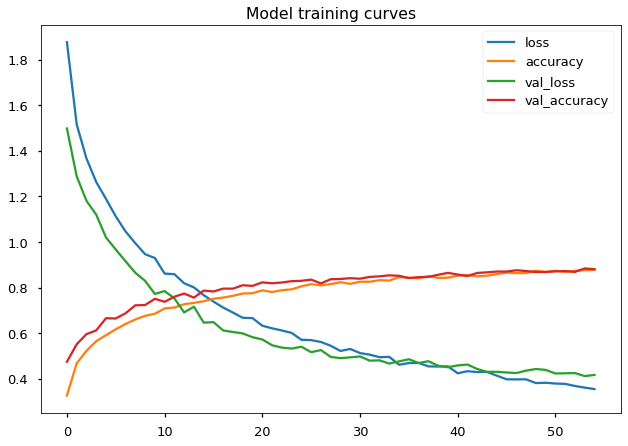

In [27]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves")

In [28]:
#Evaluamos la precisión

test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.880366325378418


In [29]:

#predicción de un archivo de audio
filename="/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/UrbanSound8K/audio/fold1/101415-3-0-2.wav"
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)
predictions = model.predict(prediction_feature)  # Realiza las predicciones en el conjunto de testeo X_test
clases_predichas = predictions.argmax(axis=-1)  # Obtiene las clases predichas a partir de la función argmax
print(clases_predichas)  # Imprime las clases predichas

[3]


In [30]:
X_test[1]

array([-2.1497850e+02,  1.0111462e+02,  1.0701711e+01,  2.9793997e+01,
        2.2425907e+00,  3.5765026e+01, -5.8683626e-02,  2.0328924e+01,
       -7.3071065e+00,  1.1149619e+01, -1.4454793e+01,  9.1833763e+00,
       -1.3252478e+01,  5.7286201e+00, -1.0526182e+01,  3.0208290e+00,
       -8.5444889e+00,  4.1735864e+00, -3.4938176e+00,  4.3296556e+00,
       -9.4101572e+00,  5.2094407e+00, -5.0576735e+00, -7.4800116e-01,
       -3.8753324e+00,  1.5019976e+00, -5.1832438e+00,  2.9086030e+00,
       -7.3149242e+00,  2.8414812e+00, -6.0032020e+00, -4.3620393e-01,
       -4.1044927e+00,  1.8234726e+00, -3.1372077e+00,  1.8012607e+00,
       -3.3252137e+00,  1.1979816e+00, -2.1982739e+00,  1.7678106e+00],
      dtype=float32)

[5 7 0 6 6 0 9 7 4 8 3 9 5 7 4 4 7 3 6 3 5 1 4 0 7 7 2]


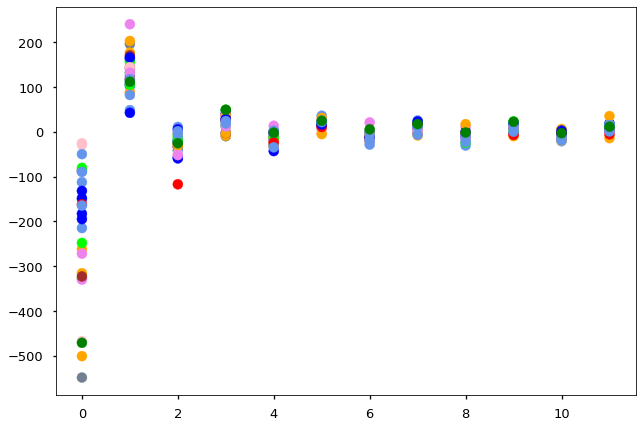

In [31]:
#predicción de testeo
predictions = model.predict(X_testgraph)  # Realiza las predicciones en el conjunto de testeo X_test
clases_predichas = predictions.argmax(axis=-1)  # Obtiene las clases predichas a partir de la función argmax
print(clases_predichas)  # Imprime las clases predichas


predicciones = labelencoder.inverse_transform(clases_predichas) 
predicciones



prednew = []

for k in range(len(predicciones)):
    if predicciones[k] == "dog_bark":  
        prednew.append("orange")

    if predicciones[k] == "drilling":  
        prednew.append("blue") 

    if predicciones[k] == "jackhammer":  
        prednew.append("cornflowerblue") 

    if predicciones[k] == "engine_idling":  
        prednew.append("lime") 

    if predicciones[k] == "siren":  
        prednew.append("slategrey") 

    if predicciones[k] == "gun_shot":  
        prednew.append("pink")

    if predicciones[k] == "street_music":  
        prednew.append("brown")

    if predicciones[k] == "air_conditioner":  
        prednew.append("violet")

    if predicciones[k] == "car_horn":  
        prednew.append("red")

    if predicciones[k] == "children_playing":  
        prednew.append("green")


prednew = np.array(prednew)


scp = pd.DataFrame(X_testgraph).T  # Convierte la lista de listas en un dataframe y lo transpone (por defecto es por columnas)

                          # Itera sobre las columnas.
for i in range(12):  

      plt.scatter([i] * len(scp.iloc[i]), scp.iloc[i],c=prednew, s=100) 

plt.style.use('seaborn-talk')

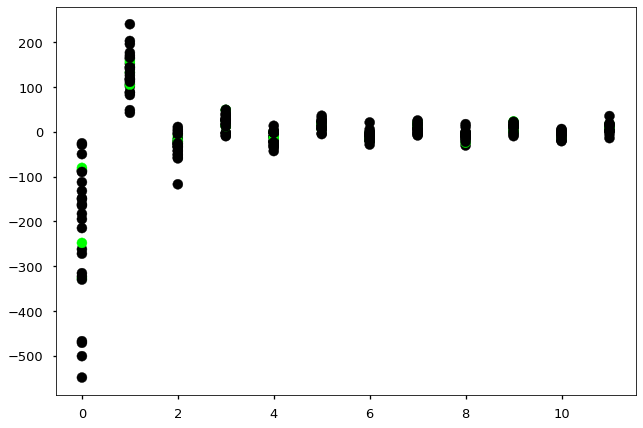

In [32]:

scp = pd.DataFrame(X_testgraph).T  # Convierte la lista de listas en un dataframe y lo transpone (por defecto es por columnas)
                          # Itera sobre las columnas.
for k in range(12):  
      
      plt.scatter([k] * len(scp.iloc[k]), scp.iloc[k],c=prednew=='lime', s=100, cmap = colors.ListedColormap(['black', 'lime'])) 

plt.style.use('seaborn-talk')
      

### Testeando algunos sonidos



Pasos

- Carga del modelo
- Carga de audio y preprocesado
- prediccción de clases con el modelo ya entrenado
- Transformación inversa de clase predicha a nombre de la clase predicha

In [33]:

#uso del modelo


modelo = load_model('/content/saved_models/audio_classification.hdf5')

filename="/content/drive/MyDrive/Uninorte/Todo_cuenta_uninorte/Puntos1-50/Splits/P5splits/Punto 01 P5.wav_segment103.wav"

#cargamos el audio y extraemos coeficientes mfcc
audio, sample_rate = librosa.load(filename, res_type='kaiser_best') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

predictions = modelo.predict(mfccs_scaled_features)  # Realiza las prediccion a los coeficientes del archivo de audio seleccionado
clase_predicha = predictions.argmax(axis=-1)  # Obtiene las clase predicha a partir de la función argmax
print(clase_predicha)
prediction_class = labelencoder.inverse_transform(clase_predicha) 
prediction_class

[9]


array(['street_music'], dtype='<U16')